# Notebook 02: Cushion Erosion Analysis

**Goal:** Calculate how cushion changes during ball flight for each CB-WR pair.

**Input:** cushion_analysis_data.csv (1,370 pairings with initial positions)

**Output:** erosion_analysis_data.csv (adds erosion metrics to each pairing)

**Key metrics to calculate:**
- Initial cushion (already have)
- Final cushion (at last frame)
- Erosion rate (yards per frame)
- Total erosion (yards closed/lost)
- Erosion pattern (Aggressive Close, Moderate Close, Maintained, Lost Ground)

## Section 1: Setup and Load Data

In [5]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ Imports complete")

✓ Imports complete


In [6]:
# Load the cushion analysis data from Notebook 01
cushion_df = pd.read_csv('../data/processed/cushion_analysis_data.csv')

print(f"Loaded cushion data: {cushion_df.shape}")
print(f"\nColumns:")
print(cushion_df.columns.tolist())
print(f"\nFirst few rows:")
print(cushion_df[['game_id', 'play_id', 'wr_name', 'cb_name', 'initial_cushion', 'route', 'epa']].head())

Loaded cushion data: (1439, 23)

Columns:
['game_id', 'play_id', 'week', 'wr_nfl_id', 'cb_nfl_id', 'wr_name', 'cb_name', 'wr_x', 'wr_y', 'cb_x', 'cb_y', 'initial_cushion', 'ball_land_x', 'ball_land_y', 'y_dist', 'x_dist', 'route', 'epa', 'yards_gained', 'team_coverage_type', 'down', 'yards_to_go', 'receiver_alignment']

First few rows:
      game_id  play_id            wr_name         cb_name  initial_cushion  \
0  2023090700      621  Amon-Ra St. Brown  L'Jarius Sneed         2.028053   
1  2023090700      736      Justin Watson  Cameron Sutton         7.028087   
2  2023090700     1001        Rashee Rice    Jerry Jacobs         8.256840   
3  2023090700     1869      Josh Reynolds  L'Jarius Sneed         3.739158   
4  2023090700     2613  Amon-Ra St. Brown  Trent McDuffie         1.415486   

    route       epa  
0   CROSS  2.850031  
1  CORNER  2.717539  
2   HITCH  1.195112  
3   HITCH  0.091114  
4      IN  1.447217  


## Section 2: Load Output Files (All Frames)

**Important:** We need ALL frames this time, not just frame 1.

**Strategy:** Load all weeks into a dictionary for quick access.

In [7]:
# Load ALL frames from output files
# This will take ~30 seconds and use ~500MB RAM

print("Loading output files (all frames)...")
print("This may take 30-60 seconds...\n")

output_dfs = {}  # Dictionary to store each week's data

for week in range(1, 19):  # Adjust if you have week 18
    df = pd.read_csv(f'../data/train/output_2023_w{week:02d}.csv')
    output_dfs[week] = df
    print(f"Week {week:2d}: {len(df):,} rows")

print(f"\n✓ Loaded {len(output_dfs)} weeks")
print(f"Total rows across all weeks: {sum(len(df) for df in output_dfs.values()):,}")

Loading output files (all frames)...
This may take 30-60 seconds...

Week  1: 32,088 rows
Week  2: 32,180 rows
Week  3: 36,080 rows
Week  4: 30,147 rows
Week  5: 29,319 rows
Week  6: 31,162 rows
Week  7: 27,443 rows
Week  8: 33,017 rows
Week  9: 28,291 rows
Week 10: 29,008 rows
Week 11: 27,623 rows
Week 12: 32,156 rows
Week 13: 29,568 rows
Week 14: 32,873 rows
Week 15: 32,715 rows
Week 16: 36,508 rows
Week 17: 33,076 rows
Week 18: 29,682 rows

✓ Loaded 18 weeks
Total rows across all weeks: 562,936


## Section 3: Calculate Cushion Timeline for One Play (Test)

**Before processing all 1,370 plays, test with one play to make sure the logic works.**

In [8]:
# Pick the first pairing to test
test_pairing = cushion_df.iloc[0]

print("Test pairing:")
print(f"  Game: {test_pairing['game_id']}")
print(f"  Play: {test_pairing['play_id']}")
print(f"  Week: {test_pairing['week']}")
print(f"  WR: {test_pairing['wr_name']} (ID: {test_pairing['wr_nfl_id']})")
print(f"  CB: {test_pairing['cb_name']} (ID: {test_pairing['cb_nfl_id']})")
print(f"  Initial cushion: {test_pairing['initial_cushion']:.2f} yards")
print(f"  Route: {test_pairing['route']}")

Test pairing:
  Game: 2023090700
  Play: 621
  Week: 1
  WR: Amon-Ra St. Brown (ID: 53541)
  CB: L'Jarius Sneed (ID: 52546)
  Initial cushion: 2.03 yards
  Route: CROSS


In [9]:
# Get all frames for this play
week = int(test_pairing['week'])
game_id = test_pairing['game_id']
play_id = test_pairing['play_id']

# Access the correct week's data
output_df = output_dfs[week]

# Filter to this specific play
play_frames = output_df[
    (output_df['game_id'] == game_id) & 
    (output_df['play_id'] == play_id)
].copy()

print(f"\nPlay has {len(play_frames)} total player-frames")
print(f"Unique frames: {play_frames['frame_id'].nunique()}")
print(f"Frame range: {play_frames['frame_id'].min()} to {play_frames['frame_id'].max()}")
print(f"\nUnique players in this play: {play_frames['nfl_id'].nunique()}")


Play has 28 total player-frames
Unique frames: 7
Frame range: 1 to 7

Unique players in this play: 4


In [10]:
# Track cushion over time for this CB-WR pair

wr_id = test_pairing['wr_nfl_id']
cb_id = test_pairing['cb_nfl_id']

# Get WR frames
wr_frames = play_frames[play_frames['nfl_id'] == wr_id].sort_values('frame_id')
# Get CB frames  
cb_frames = play_frames[play_frames['nfl_id'] == cb_id].sort_values('frame_id')

print(f"WR frames: {len(wr_frames)}")
print(f"CB frames: {len(cb_frames)}")

# Calculate cushion at each frame where both players exist
cushion_timeline = []

for frame in sorted(play_frames['frame_id'].unique()):
    wr_pos = wr_frames[wr_frames['frame_id'] == frame]
    cb_pos = cb_frames[cb_frames['frame_id'] == frame]
    
    if len(wr_pos) > 0 and len(cb_pos) > 0:
        # Both players exist in this frame
        wr_x = wr_pos['x'].values[0]
        wr_y = wr_pos['y'].values[0]
        cb_x = cb_pos['x'].values[0]
        cb_y = cb_pos['y'].values[0]
        
        # Calculate distance
        distance = np.sqrt((wr_x - cb_x)**2 + (wr_y - cb_y)**2)
        
        cushion_timeline.append({
            'frame': frame,
            'cushion': distance,
            'wr_x': wr_x,
            'wr_y': wr_y,
            'cb_x': cb_x,
            'cb_y': cb_y
        })

print(f"\nCushion calculated for {len(cushion_timeline)} frames")
print(f"\nCushion over time:")
for c in cushion_timeline:
    print(f"  Frame {c['frame']:2d}: {c['cushion']:5.2f} yards")

WR frames: 7
CB frames: 7

Cushion calculated for 7 frames

Cushion over time:
  Frame  1:  2.03 yards
  Frame  2:  2.80 yards
  Frame  3:  4.03 yards
  Frame  4:  5.43 yards
  Frame  5:  6.90 yards
  Frame  6:  8.39 yards
  Frame  7:  9.89 yards


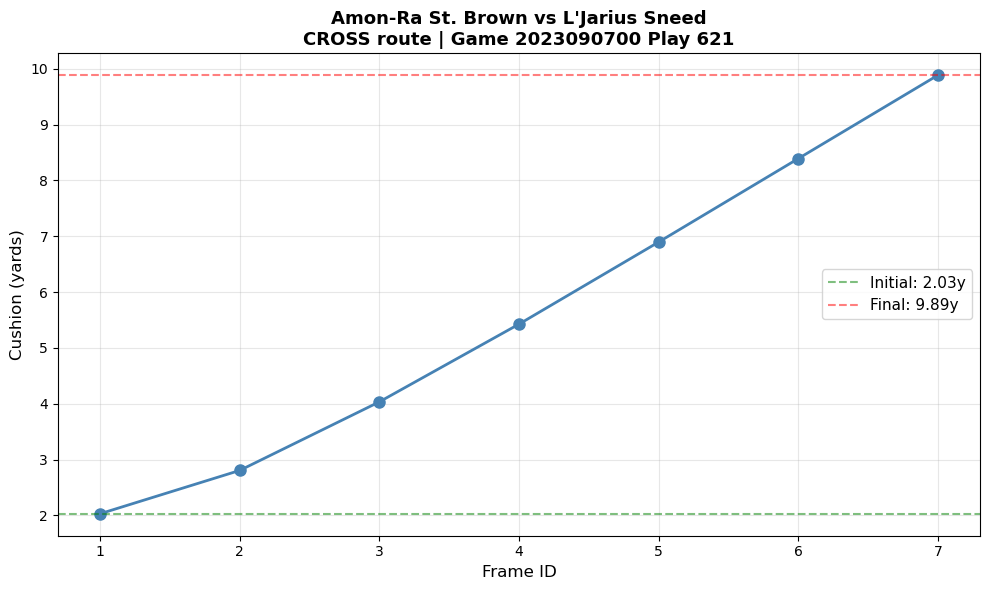


Erosion metrics:
  Initial cushion: 2.03 yards
  Final cushion: 9.89 yards
  Total erosion: -7.86 yards
  Frames: 7
  Erosion rate: -1.123 yards/frame
  Pattern: WR creating separation


In [11]:
# Visualize cushion over time for test play

if len(cushion_timeline) > 0:
    frames = [c['frame'] for c in cushion_timeline]
    cushions = [c['cushion'] for c in cushion_timeline]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(frames, cushions, marker='o', linewidth=2, markersize=8, color='steelblue')
    ax.axhline(y=cushions[0], color='green', linestyle='--', alpha=0.5, label=f'Initial: {cushions[0]:.2f}y')
    ax.axhline(y=cushions[-1], color='red', linestyle='--', alpha=0.5, label=f'Final: {cushions[-1]:.2f}y')
    
    ax.set_xlabel('Frame ID', fontsize=12)
    ax.set_ylabel('Cushion (yards)', fontsize=12)
    ax.set_title(f'{test_pairing["wr_name"]} vs {test_pairing["cb_name"]}\n'
                 f'{test_pairing["route"]} route | Game {game_id} Play {play_id}', 
                 fontsize=13, weight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate erosion metrics for this play
    initial = cushions[0]
    final = cushions[-1]
    num_frames = len(cushions)
    erosion_rate = (initial - final) / num_frames
    
    print(f"\nErosion metrics:")
    print(f"  Initial cushion: {initial:.2f} yards")
    print(f"  Final cushion: {final:.2f} yards")
    print(f"  Total erosion: {initial - final:.2f} yards")
    print(f"  Frames: {num_frames}")
    print(f"  Erosion rate: {erosion_rate:.3f} yards/frame")
    
    if erosion_rate > 0:
        print(f"  Pattern: CB closing gap")
    elif erosion_rate < 0:
        print(f"  Pattern: WR creating separation")
    else:
        print(f"  Pattern: Maintaining distance")
else:
    print("⚠ No cushion timeline data to plot")

## Section 4: Create Function to Calculate Erosion Metrics

**Now that we've tested the logic, wrap it in a function for all plays.**

In [12]:
def calculate_erosion_metrics(pairing_row, output_dfs):
    """
    Calculate cushion erosion metrics for one CB-WR pairing.
    
    Parameters:
    -----------
    pairing_row : pandas Series
        One row from cushion_df with pairing info
    output_dfs : dict
        Dictionary of output dataframes by week
    
    Returns:
    --------
    dict : Erosion metrics (or None if insufficient data)
    """
    
    # Extract identifiers
    week = int(pairing_row['week'])
    game_id = pairing_row['game_id']
    play_id = pairing_row['play_id']
    wr_id = pairing_row['wr_nfl_id']
    cb_id = pairing_row['cb_nfl_id']
    
    # Get play frames from correct week
    output_df = output_dfs[week]
    play_frames = output_df[
        (output_df['game_id'] == game_id) & 
        (output_df['play_id'] == play_id)
    ]
    
    # Get player frames
    wr_frames = play_frames[play_frames['nfl_id'] == wr_id].sort_values('frame_id')
    cb_frames = play_frames[play_frames['nfl_id'] == cb_id].sort_values('frame_id')
    
    # Calculate cushion timeline
    cushions = []
    for frame in sorted(play_frames['frame_id'].unique()):
        wr_pos = wr_frames[wr_frames['frame_id'] == frame]
        cb_pos = cb_frames[cb_frames['frame_id'] == frame]
        
        if len(wr_pos) > 0 and len(cb_pos) > 0:
            distance = np.sqrt(
                (wr_pos['x'].values[0] - cb_pos['x'].values[0])**2 + 
                (wr_pos['y'].values[0] - cb_pos['y'].values[0])**2
            )
            cushions.append(distance)
    
    # Need at least 2 frames to calculate erosion
    if len(cushions) < 2:
        return None
    
    # Calculate metrics
    initial_cushion = cushions[0]
    final_cushion = cushions[-1]
    num_frames = len(cushions)
    total_erosion = initial_cushion - final_cushion
    erosion_rate = total_erosion / num_frames
    pct_maintained = (final_cushion / initial_cushion * 100) if initial_cushion > 0 else 0
    
    # Classify pattern
    if erosion_rate > 0.4:
        pattern = 'Aggressive Close'
    elif erosion_rate > 0.2:
        pattern = 'Moderate Close'
    elif erosion_rate > -0.1:
        pattern = 'Maintained'
    else:
        pattern = 'Lost Ground'
    
    return {
        'initial_cushion_check': initial_cushion,  # Should match cushion_df
        'final_cushion': final_cushion,
        'num_frames': num_frames,
        'total_erosion': total_erosion,
        'erosion_rate': erosion_rate,
        'pct_maintained': pct_maintained,
        'pattern': pattern
    }

print("✓ Function defined")

✓ Function defined


In [13]:
# Test the function on our test pairing
test_result = calculate_erosion_metrics(test_pairing, output_dfs)

if test_result:
    print("✓ Function works!\n")
    print("Test result:")
    for key, value in test_result.items():
        print(f"  {key:25} {value}")
else:
    print("⚠ Function returned None - check data availability")

✓ Function works!

Test result:
  initial_cushion_check     2.0280532537386735
  final_cushion             9.88611652773727
  num_frames                7
  total_erosion             -7.858063273998597
  erosion_rate              -1.1225804677140852
  pct_maintained            487.4682905644821
  pattern                   Lost Ground


## Section 5: Process All Pairings

**Apply the function to all 1,370 pairings.**

**This will take 2-5 minutes** depending on your computer.

In [14]:
print("Processing all pairings...")
print("This will take 2-5 minutes...\n")

erosion_results = []
failed_count = 0

for idx, row in cushion_df.iterrows():
    result = calculate_erosion_metrics(row, output_dfs)
    
    if result:
        erosion_results.append(result)
    else:
        failed_count += 1
    
    # Progress tracking
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(cushion_df)} pairings...")

print(f"\n✓ Processing complete!")
print(f"Successful: {len(erosion_results)}")
print(f"Failed: {failed_count}")
print(f"Success rate: {len(erosion_results) / len(cushion_df) * 100:.1f}%")

Processing all pairings...
This will take 2-5 minutes...

Processed 100/1439 pairings...
Processed 200/1439 pairings...
Processed 300/1439 pairings...
Processed 400/1439 pairings...
Processed 500/1439 pairings...
Processed 600/1439 pairings...
Processed 700/1439 pairings...
Processed 800/1439 pairings...
Processed 900/1439 pairings...
Processed 1000/1439 pairings...
Processed 1100/1439 pairings...
Processed 1200/1439 pairings...
Processed 1300/1439 pairings...
Processed 1400/1439 pairings...

✓ Processing complete!
Successful: 1439
Failed: 0
Success rate: 100.0%


In [15]:
# Convert erosion results to DataFrame
erosion_df = pd.DataFrame(erosion_results)

print(f"Erosion DataFrame shape: {erosion_df.shape}")
print(f"\nColumns:")
print(erosion_df.columns.tolist())
print(f"\nFirst few rows:")
print(erosion_df.head())

Erosion DataFrame shape: (1439, 7)

Columns:
['initial_cushion_check', 'final_cushion', 'num_frames', 'total_erosion', 'erosion_rate', 'pct_maintained', 'pattern']

First few rows:
   initial_cushion_check  final_cushion  num_frames  total_erosion  \
0               2.028053       9.886117           7      -7.858063   
1               7.028087      10.656472          15      -3.628386   
2               8.256840      13.058350          12      -4.801510   
3               3.739158       3.728284           7       0.010874   
4               1.415486       1.725688          12      -0.310202   

   erosion_rate  pct_maintained      pattern  
0     -1.122580      487.468291  Lost Ground  
1     -0.241892      151.626936  Lost Ground  
2     -0.400126      158.151914  Lost Ground  
3      0.001553       99.709189   Maintained  
4     -0.025850      121.914914   Maintained  


In [16]:
# Merge erosion metrics back with cushion_df
# Use index to align since we processed in order

# First, add index to track which succeeded
cushion_df_with_erosion = cushion_df.copy()

# Add erosion metrics (will have NaN for failed rows)
for col in erosion_df.columns:
    cushion_df_with_erosion[col] = np.nan

# Fill in the successful ones
success_indices = [i for i, row in cushion_df.iterrows() 
                   if calculate_erosion_metrics(row, output_dfs) is not None]

for i, idx in enumerate(success_indices):
    for col in erosion_df.columns:
        cushion_df_with_erosion.loc[idx, col] = erosion_df.iloc[i][col]

# Drop rows where erosion calculation failed
final_df = cushion_df_with_erosion.dropna(subset=['erosion_rate']).copy()

print(f"Final DataFrame: {final_df.shape}")
print(f"Rows retained: {len(final_df)}/{len(cushion_df)} ({len(final_df)/len(cushion_df)*100:.1f}%)")

/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_66321/1480207555.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Lost Ground' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  cushion_df_with_erosion.loc[idx, col] = erosion_df.iloc[i][col]


Final DataFrame: (1439, 30)
Rows retained: 1439/1439 (100.0%)


## Section 6: Validate Erosion Data

In [17]:
print("="*60)
print("EROSION DATA VALIDATION")
print("="*60)

print(f"\nTotal pairings with erosion data: {len(final_df):,}")

print("\n--- Erosion Rate (yards/frame) ---")
print(final_df['erosion_rate'].describe())

print("\n--- Erosion Pattern Distribution ---")
print(final_df['pattern'].value_counts())

print("\n--- Number of Frames ---")
print(final_df['num_frames'].describe())

print("\n--- Total Erosion (yards) ---")
print(final_df['total_erosion'].describe())

print("\n--- Percent Cushion Maintained ---")
print(final_df['pct_maintained'].describe())

EROSION DATA VALIDATION

Total pairings with erosion data: 1,439

--- Erosion Rate (yards/frame) ---
count    1439.000000
mean       -0.008680
std         0.248962
min        -1.405508
25%        -0.057534
50%         0.024492
75%         0.108680
max         0.877239
Name: erosion_rate, dtype: float64

--- Erosion Pattern Distribution ---
pattern
Maintained          952
Lost Ground         273
Moderate Close      194
Aggressive Close     20
Name: count, dtype: int64

--- Number of Frames ---
count    1439.000000
mean       12.067408
std         4.857816
min         5.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        31.000000
Name: num_frames, dtype: float64

--- Total Erosion (yards) ---
count    1439.000000
mean       -0.289452
std         3.025439
min       -20.071485
25%        -0.669866
50%         0.281681
75%         1.199670
max         8.646325
Name: total_erosion, dtype: float64

--- Percent Cushion Maintained ---
count    1439.000000
mean     

In [18]:
# Analyze erosion patterns by route
print("\n" + "="*60)
print("EROSION BY ROUTE TYPE")
print("="*60)

for route in ['HITCH', 'OUT', 'SLANT', 'CROSS', 'GO', 'IN']:
    route_df = final_df[final_df['route'] == route]
    
    if len(route_df) >= 20:
        print(f"\n{route} (n={len(route_df)}):")
        print(f"  Avg erosion rate: {route_df['erosion_rate'].mean():6.3f} y/frame")
        print(f"  Median erosion:   {route_df['erosion_rate'].median():6.3f} y/frame")
        print(f"  Pattern breakdown:")
        patterns = route_df['pattern'].value_counts()
        for pattern, count in patterns.items():
            pct = count / len(route_df) * 100
            print(f"    {pattern:20} {count:3d} ({pct:5.1f}%)")


EROSION BY ROUTE TYPE

HITCH (n=239):
  Avg erosion rate:  0.078 y/frame
  Median erosion:    0.080 y/frame
  Pattern breakdown:
    Maintained           154 ( 64.4%)
    Moderate Close        55 ( 23.0%)
    Lost Ground           26 ( 10.9%)
    Aggressive Close       4 (  1.7%)

OUT (n=256):
  Avg erosion rate: -0.074 y/frame
  Median erosion:   -0.006 y/frame
  Pattern breakdown:
    Maintained           156 ( 60.9%)
    Lost Ground           75 ( 29.3%)
    Moderate Close        25 (  9.8%)

SLANT (n=214):
  Avg erosion rate:  0.063 y/frame
  Median erosion:    0.058 y/frame
  Pattern breakdown:
    Maintained           139 ( 65.0%)
    Moderate Close        45 ( 21.0%)
    Lost Ground           24 ( 11.2%)
    Aggressive Close       6 (  2.8%)

CROSS (n=207):
  Avg erosion rate: -0.034 y/frame
  Median erosion:    0.032 y/frame
  Pattern breakdown:
    Maintained           141 ( 68.1%)
    Lost Ground           41 ( 19.8%)
    Moderate Close        21 ( 10.1%)
    Aggressive Clos

## Section 7: Save Results

In [19]:
# Save the complete dataset with erosion metrics
output_path = '../data/processed/erosion_analysis_data.csv'

final_df.to_csv(output_path, index=False)

print(f"✓ Data saved to: {output_path}")
print(f"\nRows: {len(final_df):,}")
print(f"Columns: {len(final_df.columns)}")
print(f"\nFile size: {final_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

✓ Data saved to: ../data/processed/erosion_analysis_data.csv

Rows: 1,439
Columns: 30

File size: 0.8 MB


## Section 8: Summary

**What we calculated:**
- Frame-by-frame cushion tracking
- Erosion rate (how fast CB closes gap)
- Erosion patterns (Aggressive, Moderate, Maintained, Lost Ground)
- Route-specific erosion tendencies

**Next step:** Notebook 03 will analyze which erosion patterns lead to best outcomes (lowest EPA)

In [20]:
print("="*60)
print("EROSION CALCULATION COMPLETE - SUMMARY")
print("="*60)

print(f"\nTotal pairings analyzed: {len(final_df):,}")
print(f"Routes covered: {final_df['route'].nunique()}")
print(f"\nAverage erosion rate: {final_df['erosion_rate'].mean():.3f} yards/frame")
print(f"Median erosion rate: {final_df['erosion_rate'].median():.3f} yards/frame")

print(f"\nErosion patterns:")
for pattern, count in final_df['pattern'].value_counts().items():
    pct = count / len(final_df) * 100
    print(f"  {pattern:20} {count:4d} ({pct:5.1f}%)")

print(f"\nData saved to: {output_path}")
print("="*60)
print("\n✓ Ready for statistical analysis in notebook 03!")

EROSION CALCULATION COMPLETE - SUMMARY

Total pairings analyzed: 1,439
Routes covered: 12

Average erosion rate: -0.009 yards/frame
Median erosion rate: 0.024 yards/frame

Erosion patterns:
  Maintained            952 ( 66.2%)
  Lost Ground           273 ( 19.0%)
  Moderate Close        194 ( 13.5%)
  Aggressive Close       20 (  1.4%)

Data saved to: ../data/processed/erosion_analysis_data.csv

✓ Ready for statistical analysis in notebook 03!



SECTION 9: CONCLUSION & KEY INSIGHTS


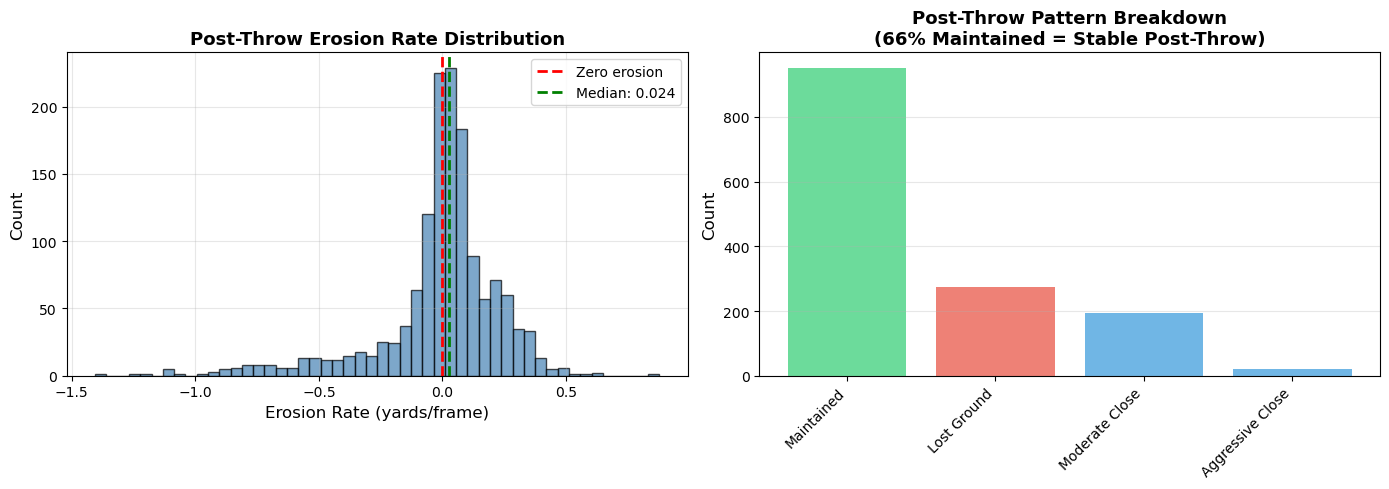

KEY INSIGHT: Post-throw adjustments are minimal!
Maintained cushion: 66.2%
Average erosion: -0.009 y/frame

→ This proves pre-throw positioning is what matters most!


In [22]:
# ============================================================================
# SECTION 9: Conclusion & Transition to Pre-Throw Analysis
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs('../visualizations', exist_ok=True)
print("\n" + "=" * 70)
print("SECTION 9: CONCLUSION & KEY INSIGHTS")
print("=" * 70)

# Distribution of erosion rates and pattern breakdown
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Erosion rate distribution
ax1.hist(final_df['erosion_rate'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero erosion')
ax1.axvline(x=final_df['erosion_rate'].median(), color='green', linestyle='--', 
           linewidth=2, label=f'Median: {final_df["erosion_rate"].median():.3f}')
ax1.set_xlabel('Erosion Rate (yards/frame)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Post-Throw Erosion Rate Distribution', fontsize=13, weight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Pattern breakdown
pattern_counts = final_df['pattern'].value_counts()
colors = ['#2ecc71' if 'Maintained' in p else '#e74c3c' if 'Lost' in p else '#3498db' 
          for p in pattern_counts.index]
ax2.bar(range(len(pattern_counts)), pattern_counts.values, color=colors, alpha=0.7)
ax2.set_xticks(range(len(pattern_counts)))
ax2.set_xticklabels(pattern_counts.index, rotation=45, ha='right')
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Post-Throw Pattern Breakdown\n(66% Maintained = Stable Post-Throw)', 
             fontsize=13, weight='bold')
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/erosion_conclusion.png', dpi=150, bbox_inches='tight')
plt.show()

print("=" * 70)
print("KEY INSIGHT: Post-throw adjustments are minimal!")
print("=" * 70)
print(f"Maintained cushion: {(final_df['pattern'] == 'Maintained').sum() / len(final_df) * 100:.1f}%")
print(f"Average erosion: {final_df['erosion_rate'].mean():.3f} y/frame")
print("\n→ This proves pre-throw positioning is what matters most!")